In [1]:
%%time
import xarray as xr
import numpy as np
import dask.array
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
xr.set_options(display_expand_data=False);

from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

import pandas as pd
from scipy.stats import skew
from scipy.stats import pearsonr
%pylab inline
import random
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.neighbors import KernelDensity
import random
from matplotlib import rcParams
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

import emcee
import logging

# Adjust the logging level for matplotlib to suppress font-related warnings
logging.getLogger('matplotlib').setLevel(logging.WARNING)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
CPU times: user 2.79 s, sys: 1.76 s, total: 4.55 s
Wall time: 36.5 s


In [6]:
%%time
data_folder = 'Provide the path to the folder of QMC sample excel and NMAE numpy files'
sample=128
# Load the parameter sample from the excel sheet
X = pd.read_excel(f'{data_folder}/QMC_sobol_samples.xlsx',
                  sheet_name=f'QMC_Sobol_sequence_{sample}',header=None)
# Load the NMAE values of the 128 simulations from the numpy array
Y_npz = np.load(f'{data_folder}/nmae_all_{sample}_ens_T_Rh.npz')

Y = Y_npz[f'nmae']

CPU times: user 11.8 ms, sys: 7.95 ms, total: 19.8 ms
Wall time: 18.6 ms


In [11]:
%%time
import warnings
warnings.filterwarnings('ignore')
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern,WhiteKernel,ConstantKernel,RBF,\
DotProduct,ExpSineSquared,RationalQuadratic

fold = np.int(8)
'''
kernel function for your Gaussian process regression
kernel = constant kernel (adds a constant value to the diagonal of the covariance matrix) +
Radial Basis Function (RBF) kernel (multiplied by 1.0 and parameterized with a 
length scale of 3 dimensions (3 features) with each feature having a length scale of 1) +
white noise to the covariance matrix with a very small noise level
'''
kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((3,1))) + WhiteKernel(noise_level=1e-10)
'''
Passing custom kernel and setting 10 restarts of the optimizer for finding the kernel's parameters
that maximize the log-marginal-likelihood
'''
model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
GPR_score = np.zeros((2,3,8)) #variables, N, fold
N = [32,64,128]
for j in range(len(N)):
    n = int(N[j]/fold)
    for k in range(fold):
        X_train = pd.concat([X.iloc[0:k*n,:],X.iloc[(k+1)*n:N[j],:]],axis=0)
        X_test = X.iloc[k*n:(k+1)*n,:]
        y_train = np.concatenate([Y[0:k*n,:],Y[(k+1)*n:N[j],:]],axis=0)
        y_test = Y[k*n:(k+1)*n,:]
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        for i in range(2):
            GPR_score[i,j,k] = r2_score(y_test[:,i], y_hat[:,i])

CPU times: user 19.5 s, sys: 11.7 ms, total: 19.5 s
Wall time: 19.5 s


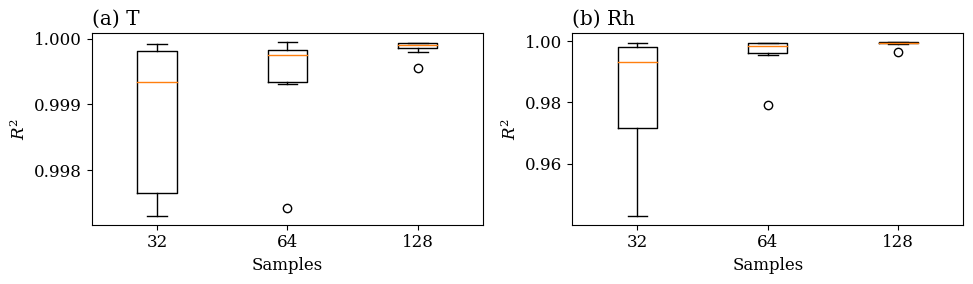

In [12]:
fig = plt.figure(figsize=(10,3))
plt.rc('font', size=12)    # fontsize of the all text
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('xtick', labelsize=12)
var_names = ['T','Rh','Ws']
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(2):
    axs = fig.add_subplot(1,2,i+1)
    axs.boxplot(GPR_score[i,:,:].T)
    axs.set_title(abc[i]+var_names[i],loc='left')
    axs.set_ylabel('$R^2$')
    axs.set_xlabel('Samples')
    axs.set_xticklabels(['32','64','128'])
plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.tight_layout()
plt.show()

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern,WhiteKernel,ConstantKernel,RBF,\
DotProduct,ExpSineSquared,RationalQuadratic


kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((3,1))) + WhiteKernel(noise_level=1e-10)
gpr_model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
gpr_model.fit(X,Y)
# Define the log-prior function
# The prior is defined as a uniform distribution between 0 and 1 for the parameters. 
# If the parameters (theta) are within this range, the log of the prior probability is 0 (since ln⁡(1)=0ln(1)=0).
# If the parameters are outside this range, the log of the prior probability is negative infinity (representing a probability of 0).

def lnprior(theta):
    if np.all(theta >= 0) and np.all(theta <= 1):
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0)


desired_nrmse = 0.0 
desired_std = 0.05  


all_samplers = {}
variables = ['T', 'RH','T & RH']
for i,var in enumerate(variables):
    
    # Set up the sampler
    ndim, nwalkers = 3, 50
    pos = [np.random.rand(ndim) for i in range(nwalkers)]
    
    # Define the log-likelihood function
    def lnlike(theta):
        if (i == 2):
            predicted_nrmse = (gpr_model.predict([theta])[:,0]+gpr_model.predict([theta])[:,1])/2
        else:
            predicted_nrmse = gpr_model.predict([theta])[:,i]
        # Gaussian likelihood centered at desired_nrmse with desired_std
        return -0.5 * ((predicted_nrmse - desired_nrmse) / desired_std)**2
    
    # Define the log-posterior function - Bayes Theorem
    def lnprob(theta):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    # Run MCMC for some steps
    nsteps = 3000
    burnin = 1000
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    samples = sampler.get_chain()
    tau = sampler.get_autocorr_time()
    print(tau)
    all_samplers[var] = sampler

100%|██████████| 3000/3000 [00:29<00:00, 102.04it/s]


[39.5061431  38.99094847 51.74906835]


100%|██████████| 3000/3000 [00:29<00:00, 102.81it/s]


[43.74903721 44.34636667 36.26898403]


100%|██████████| 3000/3000 [00:51<00:00, 58.49it/s]

[42.99881618 42.74232324 51.01192945]


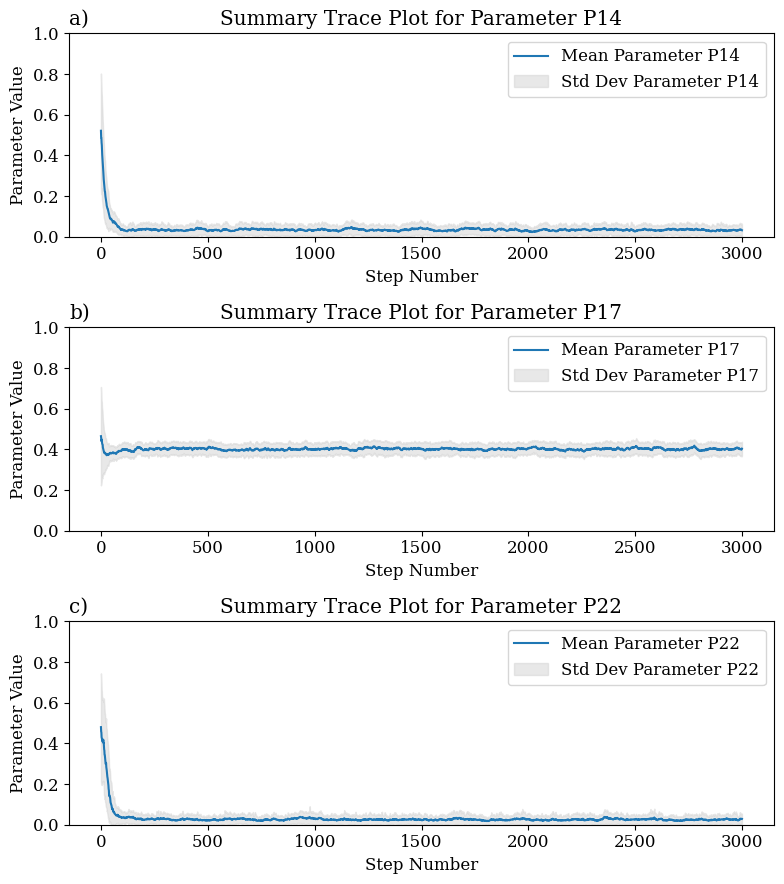

In [8]:
# Checking the parameter values over iterations
# Calculate the mean and standard deviation (or other spread measure) across walkers
chains_incl_burned = (all_samplers['T & RH']).chain
mean_chains = np.mean(chains_incl_burned, axis=0)
std_chains = np.std(chains_incl_burned, axis=0)
params = ['P14', 'P17', 'P22']
abc = ['a)', 'b)', 'c)']
# Number of parameters
num_params = mean_chains.shape[1]

# Create a larger figure for all subplots
plt.figure(figsize=(8, 3 * num_params))

for i in range(num_params):
    # Create subplot for each parameter
    plt.subplot(num_params, 1, i + 1)
    plt.plot(mean_chains[:, i], label=f'Mean Parameter {params[i]}')
    plt.fill_between(range(mean_chains.shape[0]),
                     mean_chains[:, i] - std_chains[:, i],
                     mean_chains[:, i] + std_chains[:, i],
                     color='lightgrey', alpha=0.5, label=f'Std Dev Parameter {params[i]}')
    plt.title(f'Summary Trace Plot for Parameter {params[i]}')
    plt.title(f'{abc[i]}',loc='left')
    plt.xlabel('Step Number')
    plt.ylabel('Parameter Value')
    plt.ylim(0, 1)
    plt.legend()

# Save the entire figure
plt.tight_layout()  # Adjusts the plots to fit into the figure area
plt.show()

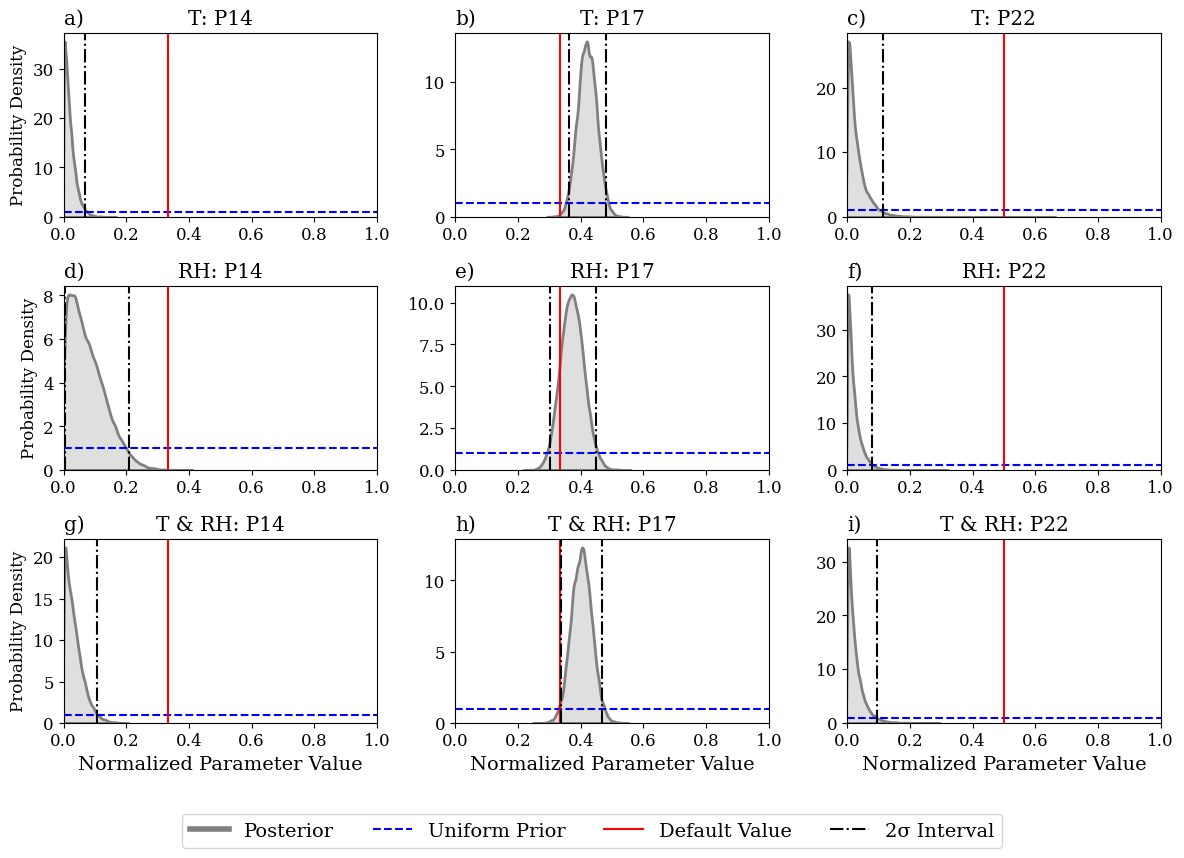

In [9]:
# Plots Posterior Distribution of parameters
# Parameter names and default values
params = ['P14', 'P17', 'P22']
defval = [0.3333, 0.3333, 0.5]

abc = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']
count = 0

# Plotting the KDE for each parameter with the uniform prior
fig, axes = plt.subplots(3, 3, figsize=(12, 8))  # 3 rows, 3 columns
    
for j,var in enumerate(all_samplers):
    all_chains = (all_samplers[var]).chain
    samples = all_chains[:, burnin:, :].reshape((-1, 3))  

    for i in range(3):
        ax = axes[j,i]

        sns.kdeplot(samples[:, i], ax=ax, fill=True, color='gray', linewidth=2)

        ax.axhline(y=1, color='blue', linestyle='--')
        ax.axvline(x=defval[i], color='red', linestyle='-')
        #ax.axvline(x=mae_256_min[var][i], color='green', linestyle='-')

        # Adding 2-sigma confidence interval
        lower, upper = np.percentile(samples[:, i], [2.5, 97.5])
        ax.axvline(x=lower, color='black', linestyle='-.')
        ax.axvline(x=upper, color='black', linestyle='-.')

        ax.set_xlim(0, 1)
        ax.set_ylabel("")
        ax.set_title(f"")
        if (i==0):
            ax.set_ylabel("Probability Density")
        if (j==2):
            ax.set_xlabel("Normalized Parameter Value", fontsize=14)
        ax.set_title(f"{abc[count]}",loc='left')
        count = count+1
        ax.set_title(f"{variables[j]}: {params[i]}",loc='center') 

    # Adding custom legend elements
    custom_lines = [Line2D([0], [0], color='gray', lw=4),
                    Line2D([0], [0], color='blue', linestyle='--'),
                    Line2D([0], [0], color='red', linestyle='-'),
                    Line2D([0], [0], color='black', linestyle='-.')]

fig.legend(custom_lines, ["Posterior", "Uniform Prior", "Default Value", "2σ Interval"], 
           loc='center', bbox_to_anchor=(0.5, -0.05), fontsize=14, ncol=4)

plt.tight_layout()
plt.show()

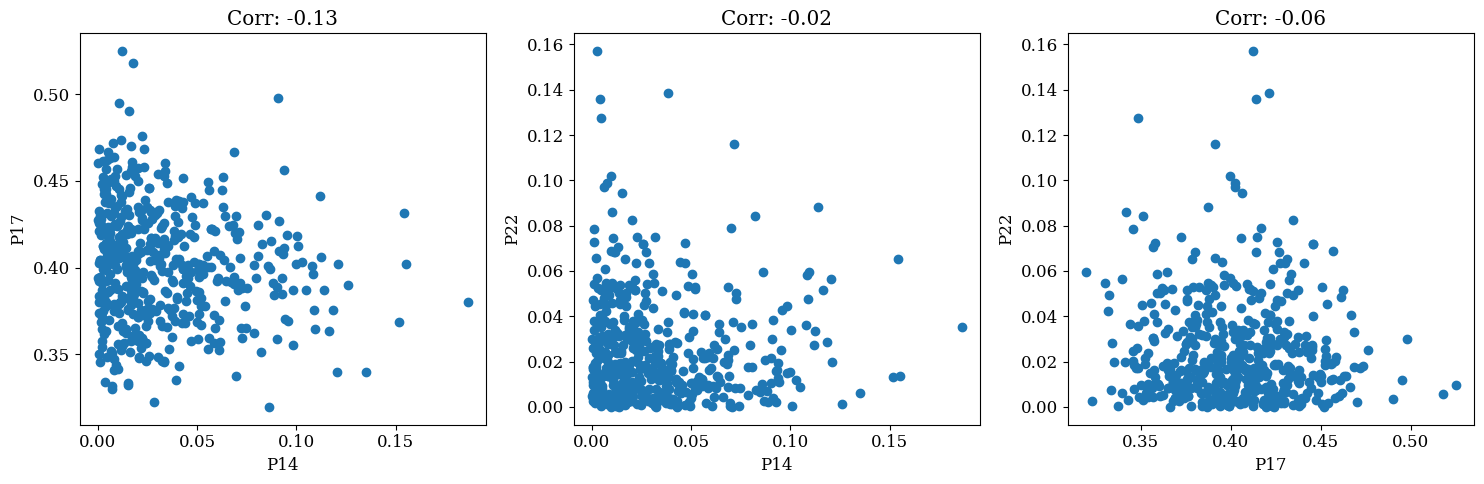

In [24]:
# Draw parameter sets from the posterior distribution
seed = 44
n_samples = 500  # or however many you can afford to run
selected_samples = samples[np.random.choice(len(samples), n_samples, replace=False)]

# Calculate the correlation coefficients
corr_01 = np.corrcoef(selected_samples[:, 0], selected_samples[:, 1])[0, 1]
corr_02 = np.corrcoef(selected_samples[:, 0], selected_samples[:, 2])[0, 1]
corr_12 = np.corrcoef(selected_samples[:, 1], selected_samples[:, 2])[0, 1]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(selected_samples[:,0], selected_samples[:,1])
ax[0].set_title(f'Corr: {corr_01:.2f}', loc='center')
ax[0].set_xlabel('P14')
ax[0].set_ylabel('P17')
ax[1].scatter(selected_samples[:,0],selected_samples[:,2])
ax[1].set_title(f'Corr: {corr_02:.2f}', loc='center')
ax[1].set_xlabel('P14')
ax[1].set_ylabel('P22')
ax[2].scatter(selected_samples[:,1],selected_samples[:,2])
ax[2].set_title(f'Corr: {corr_12:.2f}', loc='center')
ax[2].set_xlabel('P17')
ax[2].set_ylabel('P22')

plt.tight_layout()
plt.show()

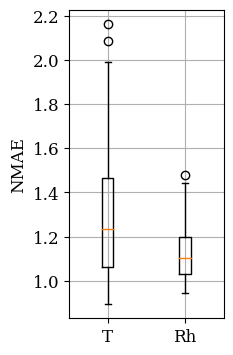

In [10]:
# Plot the box plots
plt.figure(figsize=(2, 4))
plt.boxplot([Y[:,0], Y[:,1]], labels=['T', 'Rh'])
plt.ylabel('NMAE')
plt.grid(True)
plt.show()